## Inital Pre-Processing with Pandas

In [1]:
# Basics
import numpy as np
import pandas as pd
import glob
# To check vessel names
import re
# To get exact lat/long
from shapely.wkt import loads
# To map the ships or coastlines
import geopandas as gpd
from geopy.distance import geodesic
# To find coastline distance
from scipy.spatial import KDTree
# For XgBoosting
import xgboost as xgb
import random
# For upsampling during the modeling
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os 
import geopandas
import shapely
from shapely.geometry import Point
import contextily as ctx

In [2]:
# Data formatting 
this_dir = "/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/east_asia"
files = glob.glob(this_dir + '/*.csv')
files = files[0:2]

# Set dtypes to avoid errors later
dtypes = {'FID': 'object', 'mmsi': 'int64', 'source_id': 'int64', 'imo': 'float64', 
          'vessel_name': 'object', 'callsign': 'object', 'vessel_type': 'object', 
          'vessel_type_code': 'float64', 'vessel_type_cargo': 'object', 'vessel_class': 'object',
          'length': 'float64', 'width': 'float64', 'flag_country': 'object', 'flag_code': 'float64',
          'destination': 'object', 'eta': 'int64', 'draught': 'float64', 'position': 'object',
          'latitude': 'float64', 'longitude': 'float64', 'sog': 'float64', 'cog': 'float64',
          'rot': 'float64', 'heading': 'int64', 'nav_status': 'object', 'nav_status_code': 'int64',
          'source': 'object', 'ts_pos_utc': 'int64', 'ts_static_utc': 'int64', 
          'dt_pos_utc': 'object', 'dt_static_utc': 'object', 'vessel_type_main': 'float64',
          'vessel_type_sub': 'float64', 'message_type': 'int64', 'eeid': 'float64', 'dtg': 'object'}

# Read each CSV file into a list of DataFrames
dfs = [pd.concat(pd.read_csv(file, dtype = dtypes, chunksize = 100000)) for file in files]

# Concatenate the DataFrames into a single DataFrame
ais = pd.concat(dfs, ignore_index=True).reset_index(drop = True)
ais['dtg'] = pd.to_datetime(ais['dtg'])
ais = ais.sort_values(['mmsi', 'dtg'])

# Fix NA names
ais.loc[ais['vessel_name'].isnull(), 'vessel_name'] = " "

# Calculate the time difference between consecutive rows for each mmsi
ais['time_diff'] = ais.groupby('mmsi')['dtg'].diff()

# Create a new column called first_occurrence based on the identified conditions
ais['first_occurrence'] = ((ais['time_diff'].isnull()) | (ais['time_diff'] > pd.Timedelta(hours=10))).astype(int)
ais['occ_num'] = ais.groupby('mmsi').agg(occ_num = ('first_occurrence', 'cumsum')) # Separate different trips

# Get distance traveled
ais['old_lat'] = ais.groupby(['mmsi', 'occ_num'])['latitude'].shift(1)
ais['old_long'] = ais.groupby(['mmsi', 'occ_num'])['longitude'].shift(1)

# Get distance and spped from consecutive readings
def calculate_distance(row):
    if pd.notna(row['old_lat']) and pd.notna(row['old_long']) and pd.notna(row['latitude']) and pd.notna(row['longitude']):
        return geodesic((row['old_lat'], row['old_long']), (row['latitude'], row['longitude'])).nautical
    else:
        return pd.NA

ais['distance'] = ais.apply(calculate_distance, axis = 1)
ais['distance'] = pd.to_numeric(ais['distance'], errors='coerce').fillna(0)
ais['speed'] = ais['distance'] / (ais['time_diff'].dt.seconds.replace(0, pd.NA) / 3600)
ais['distance'] = ais.groupby(['mmsi', 'occ_num']).agg(distance = ('distance', 'cumsum'))

# Check naming conventions
# Look for sketchy names
def check_net_name(name):
    name = name.lower()
    net_name = ('%' in name or 
                'buoy' in name or 
                'net' in name or 
                bool(re.search(r"\d+v", name)))
    if net_name is np.nan:
        net_name = 0
    return net_name

ship_names = ais['vessel_name'].astype('str').unique()
net_names = [check_net_name(name) for name in ship_names]
ais['net_name'] = ais['vessel_name']\
    .map(dict(zip(ship_names, net_names)))
# Look for bad mmsi values
ais['mmsi_length'] = ais['mmsi'].astype('str').str.len() != 9

del ship_names, net_names

In [3]:
ais.head(5)

,FID,mmsi,source_id,imo,vessel_name,callsign,vessel_type,vessel_type_code,vessel_type_cargo,vessel_class,...,dtg,time_diff,first_occurrence,occ_num,old_lat,old_long,distance,speed,net_name,mmsi_length
434371,b3c1ed73afc71f09db9e09402cbedb1b,0,139,NaN,UNAVAILABLE,NaN,Fishing,30.0,NaN,B,...,2023-10-15 19:07:12,NaT,1,1,NaN,NaN,0.000000,NaN,False,True
435236,f7027fee7166017bc3cfe0476e958cbd,0,139,NaN,UNAVAILABLE,NaN,Fishing,30.0,NaN,B,...,2023-10-15 19:17:12,0 days 00:10:00,0,1,22.5740,120.3233,0.011959,0.071753,False,True
443873,201f955a0e4bccaf42bab385ffb077d3,0,153,NaN,PERMATA 168,NaN,UNAVAILABLE,NaN,NaN,NaN,...,2023-10-15 19:17:31,0 days 00:00:19,0,1,22.5742,120.3233,0.011959,0.0,False,True
452988,1cb66403f32e872177299a15ccf5510f,0,139,NaN,UNAVAILABLE,NaN,Fishing,30.0,NaN,B,...,2023-10-15 19:22:12,0 days 00:04:41,0,1,22.5742,120.3233,0.011959,0.0,False,True
435581,f1f4f403730571eb691b84547236e1b1,0,139,NaN,AIS TEST,NaN,Cargo,70.0,NaN,NaN,...,2023-10-15 19:27:12,0 days 00:05:00,0,1,22.5742,120.3233,0.020119,0.097922,False,True


In [12]:
spawn_dict = {}
for index, row in new_vessels.iterrows():
    # Combine mmsi and occ_num to create the key
    key = (row['mmsi'], row['occ_num'])
    # Assign the value of 'spawn_offshore' to the key in the dictionary
    spawn_dict[key] = row['spawn_offshore']
    
ais['spawn_offshore'] = ais.apply(lambda row: (row['mmsi'], row['occ_num']), axis=1)\
    .map(spawn_dict)
ais['spawn_offshore'] = ais['spawn_offshore'].fillna(False)

In [12]:
# Check for starting in water

# Read in coastline data from https://www.naturalearthdata.com/downloads/10m-physical-vectors/
coastline = pd.concat([gpd.read_file("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/data/ne_10m_land/ne_10m_land.shp"), 
                       gpd.read_file("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/data/ne_10m_minor_islands/ne_10m_minor_islands.shp")])
coastline = coastline.cx[min(ais['longitude'])-1:max(ais['longitude'])+1, 
                         min(ais['latitude'])-1:max(ais['latitude'])+1].geometry

# Make function to find coastline distance
def distance_to_coast(df, coastline):
    # Get coordinates of all of the ships
    ship_coords = list(df.apply(lambda x: (x.longitude, x.latitude), 
                                axis = 1))
    # Get coordinates of the coastlines
    coast_coords = [] 
    for geom in coastline.geometry:
        if geom.geom_type == 'Polygon':
            coast_coords.extend(list(geom.exterior.coords))
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                coast_coords.extend(list(polygon.exterior.coords))
    # Use KDTree to find the nearest points to each ship
    tree = KDTree(coast_coords)
    idx = tree.query(ship_coords, k=1)[1]
    coast_points = pd.Series(coast_coords).iloc[idx]
    # Get the distances in nautical miles
    naut_dist = [geodesic((ship[1], ship[0]), (coast[1], coast[0])).nautical for ship, coast in zip(ship_coords, list(coast_points))]
    # Insert into the dataframe
    df['distance_to_coast'] = naut_dist

    return df

# Find distance to shore at start
new_vessels = ais.loc[ais['first_occurrence'] == 1, ['mmsi', 'occ_num', 'latitude', 'longitude']]
new_vessels = distance_to_coast(new_vessels, coastline)
new_vessels['spawn_offshore'] = new_vessels['distance_to_coast'] >= 1
ais = pd.merge(ais, new_vessels[['mmsi', 'occ_num', 'distance_to_coast']], on=['mmsi', 'occ_num'], how='left')

#first_time = ais['dtg'].min()
#new_vessels = ais.loc[(ais['first_occurrence'] == 1) & (ais['dtg'] - first_time >= pd.Timedelta(hours = 4)), 
 #                     ['mmsi', 'occ_num', 'latitude', 'longitude']]

#new_vessels = distance_to_coast(new_vessels, coastline)
#new_vessels['spawn_offshore'] = new_vessels['distance_to_coast'] >= 1


# Make dictionary and map to dataframe
spawn_dict = {}
for index, row in new_vessels.iterrows():
    # Combine mmsi and occ_num to create the key
    key = (row['mmsi'], row['occ_num'])
    # Assign the value of 'spawn_offshore' to the key in the dictionary
    spawn_dict[key] = row['spawn_offshore']
    
ais['spawn_offshore'] = ais.apply(lambda row: (row['mmsi'], row['occ_num']), axis=1)\
    .map(spawn_dict)
ais['spawn_offshore'] = ais['spawn_offshore'].fillna(False)

del index, row, key, coastline, spawn_dict, new_vessels

In [14]:
ais['spoof'] = ais['speed'] >= 65 # World record is 58.1, so allow for some measurement error 
ais['spoof'] = ais.groupby(['mmsi', 'occ_num'])['spoof'].transform('max')

In [15]:
# Add all potential issues together
ais['red_flags'] = ais['net_name'].astype('int') + ais['mmsi_length'].astype('int') + \
    ais['spawn_offshore'].astype('int') + ais['spoof'].astype('int')

# Get rid of extraneous columns
ais2 = ais.loc[:, ['mmsi', 'occ_num', 'longitude', 'latitude', 'sog', 'cog', 'rot', 
                  'distance','time_diff', 'dtg', 'net_name', 'mmsi_length', 'spawn_offshore', 'spoof', 
                  'red_flags']]

In [16]:
ais2.head(10)

,mmsi,occ_num,longitude,latitude,sog,cog,rot,distance,time_diff,dtg,net_name,mmsi_length,spawn_offshore,spoof,red_flags
434371,0,1,120.3233,22.5740,0.1,0.0,0.0,0.000000,NaT,2023-10-15 19:07:12,False,True,False,False,1
435236,0,1,120.3233,22.5742,0.0,0.0,0.0,0.011959,0 days 00:10:00,2023-10-15 19:17:12,False,True,False,False,1
443873,0,1,120.3233,22.5742,0.0,0.0,0.0,0.011959,0 days 00:00:19,2023-10-15 19:17:31,False,True,False,False,1
452988,0,1,120.3233,22.5742,0.3,0.0,0.0,0.011959,0 days 00:04:41,2023-10-15 19:22:12,False,True,False,False,1
435581,0,1,120.3234,22.5743,0.1,0.0,0.0,0.020119,0 days 00:05:00,2023-10-15 19:27:12,False,True,False,False,1
453177,0,1,120.3233,22.5743,0.2,0.0,0.0,0.025672,0 days 00:05:00,2023-10-15 19:32:12,False,True,False,False,1
453485,0,1,120.3233,22.5743,0.3,0.0,0.0,0.025672,0 days 00:05:00,2023-10-15 19:37:12,False,True,False,False,1
436857,0,1,120.3234,22.5746,1.6,0.0,0.0,0.044450,0 days 00:15:00,2023-10-15 19:52:12,False,True,False,False,1
506563,0,1,120.3233,22.5743,0.0,0.0,0.0,0.063228,0 days 00:05:00,2023-10-15 19:57:12,False,True,False,False,1
522307,1,1,122.9217,26.3707,9.8,225.8,0.0,0.000000,NaT,2023-10-15 19:14:04,False,True,False,True,2


## Geospatial Maps

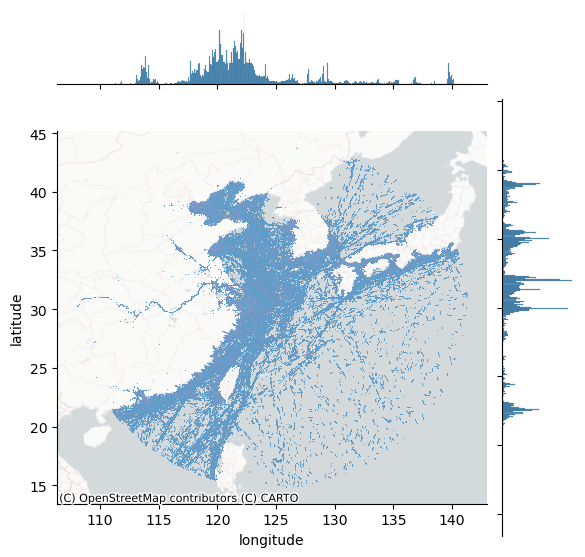

In [40]:
import seaborn
import contextily

joint_axes = seaborn.jointplot(x="longitude", y="latitude", data=ais2, s=0.5);

contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
);

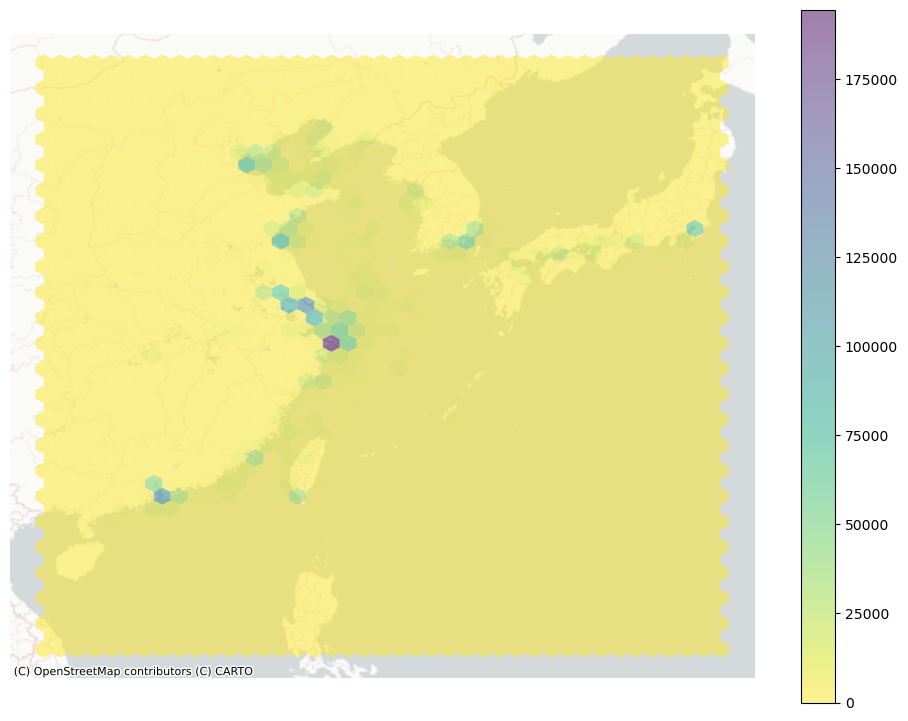

In [44]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12, 9))
# Generate and add hexbin with 50 hexagons in each
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap

hb = ax.hexbin(
    ais2['longitude'],
    ais2['latitude'],
    gridsize=40,
    linewidths=0,
    alpha=0.5,
    cmap="viridis_r",
)

# Add basemap
contextily.add_basemap(
    ax,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels
);

# Add colorbar
plt.colorbar(hb)
# Remove axes
ax.set_axis_off()

## Attempting hot spots

In [50]:
## Want to find points that are close to each other but also have diferent mmsi
## Want to focus on points with more red flags

## "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

In [62]:
## lets try to make a grid over our map
gdf = geopandas.GeoDataFrame(ais2, 
            geometry=geopandas.points_from_xy(ais2.longitude, ais2.latitude),
            crs='EPSG:4326')

gdf = gdf.drop(columns=['latitude', 'longitude'])

In [63]:
gdf

,mmsi,occ_num,sog,cog,rot,distance,time_diff,distance_to_coast,dtg,net_name,mmsi_length,spawn_offshore,spoof,red_flags,geometry
0,2,1,7.9,184.0,0.0,0.000000,NaT,108.056031,2023-10-29 19:41:55,True,True,True,True,4,POINT (126.80000 30.76210)
1,2,1,1.2,0.0,0.0,620.792917,0 days 00:10:40,108.056031,2023-10-29 19:52:35,True,True,True,True,4,POINT (118.88340 38.82100)
2,2,1,1.2,0.0,0.0,620.792917,0 days 00:04:00,108.056031,2023-10-29 19:56:35,False,True,True,True,3,POINT (118.88340 38.82100)
3,4,1,0.0,42.0,0.0,0.000000,NaT,0.715705,2023-10-29 19:02:06,False,True,False,False,1,POINT (122.02170 40.15830)
4,4,1,0.0,42.0,0.0,0.000000,0 days 00:06:09,0.715705,2023-10-29 19:08:15,False,True,False,False,1,POINT (122.02170 40.15830)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429747,1073741823,1,0.2,8.0,0.0,0.019105,0 days 00:08:14,7.872260,2023-10-29 19:25:00,False,True,True,False,2,POINT (122.78600 30.30100)
429748,1073741823,1,0.3,8.0,0.0,0.034955,0 days 00:13:25,7.872260,2023-10-29 19:38:25,False,True,True,False,2,POINT (122.78580 30.30080)
429749,1073741823,1,0.6,299.0,0.0,0.040149,0 days 00:05:37,7.872260,2023-10-29 19:44:02,False,True,True,False,2,POINT (122.78570 30.30080)
429750,1073741823,1,0.6,8.0,0.0,0.052139,0 days 00:10:38,7.872260,2023-10-29 19:54:40,False,True,True,False,2,POINT (122.78550 30.30070)


In [64]:
gdf.total_bounds

array([108.2197,  14.8633, 141.295 ,  42.8713])

In [65]:
## we have our gris be .1 lat for .1 long 
xmin, ymin, xmax, ymax= gdf.total_bounds

cell_size = 0.1 ## about 6-7 miles near equator

# Convert degrees to meters for creating grid cells
#degrees_to_meters = 111000  # Approximate value at equator
#cell_size_meters = cell_size * degrees_to_meters

# Create grid cells
x_range = np.arange(np.floor(xmin), np.ceil(xmax), cell_size)
y_range = np.arange(np.floor(ymin), np.ceil(ymax), cell_size)

# projection of the grid
crs = "EPSG:4326"

# create the cells in a loop
grid_cells = []

# Create grid cell polygons
for x in x_range:
    for y in y_range:
        cell_polygon = shapely.geometry.box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell_polygon)

# Create a GeoDataFrame from grid cell polygons
grid_df = geopandas.GeoDataFrame(geometry=grid_cells, crs=crs)

In [12]:
grid_df.head(5)

,geometry
0,"POLYGON ((108.10000 14.00000, 108.10000 14.100..."
1,"POLYGON ((108.10000 14.10000, 108.10000 14.200..."
2,"POLYGON ((108.10000 14.20000, 108.10000 14.300..."
3,"POLYGON ((108.10000 14.30000, 108.10000 14.400..."
4,"POLYGON ((108.10000 14.40000, 108.10000 14.500..."


In [68]:
## dont care about having different colors for ais sgnals in plot
gdf['tester'] = 1

In [66]:
gdf.head(5)

,mmsi,occ_num,sog,cog,rot,distance,time_diff,distance_to_coast,dtg,net_name,mmsi_length,spawn_offshore,spoof,red_flags,geometry
0,2,1,7.9,184.0,0.0,0.000000,NaT,108.056031,2023-10-29 19:41:55,True,True,True,True,4,POINT (126.80000 30.76210)
1,2,1,1.2,0.0,0.0,620.792917,0 days 00:10:40,108.056031,2023-10-29 19:52:35,True,True,True,True,4,POINT (118.88340 38.82100)
2,2,1,1.2,0.0,0.0,620.792917,0 days 00:04:00,108.056031,2023-10-29 19:56:35,False,True,True,True,3,POINT (118.88340 38.82100)
3,4,1,0.0,42.0,0.0,0.000000,NaT,0.715705,2023-10-29 19:02:06,False,True,False,False,1,POINT (122.02170 40.15830)
4,4,1,0.0,42.0,0.0,0.000000,0 days 00:06:09,0.715705,2023-10-29 19:08:15,False,True,False,False,1,POINT (122.02170 40.15830)


(106.56593500000001,
 142.94876499999998,
 13.462900000000001,
 44.271699999999996)

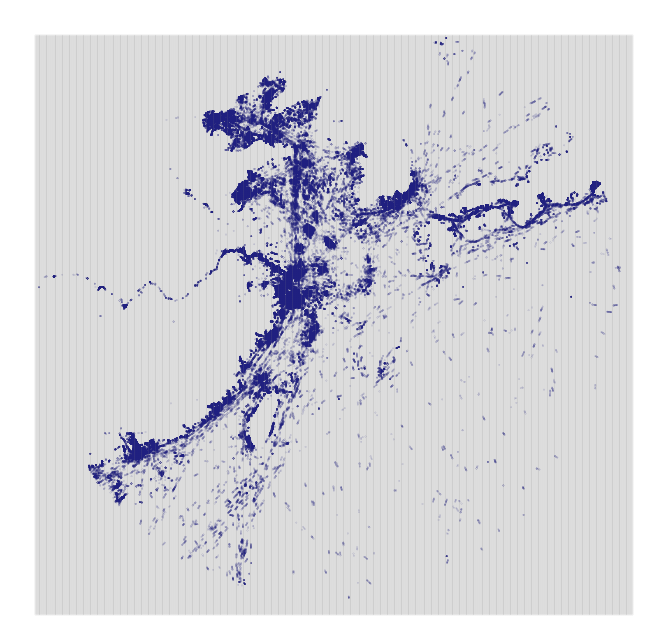

In [69]:
## plot signals with grid overlay
ax = gdf.plot(markersize=.005, figsize=(12, 8), column='tester', cmap='jet')
plt.autoscale(False)
grid_df.plot(ax=ax, facecolor="none", edgecolor='grey', linewidth=0.1)
ax.axis("off")

In [70]:
## now each point is associated with the box it belongs in 
merged = geopandas.sjoin(gdf, grid_df, how='left', predicate='intersects')
merged.rename(columns={'index_right': 'grid_num'}, inplace=True)

In [71]:
merged.head(3)

,mmsi,occ_num,sog,cog,rot,distance,time_diff,distance_to_coast,dtg,net_name,mmsi_length,spawn_offshore,spoof,red_flags,geometry,tester,grid_num
0,2,1,7.9,184.0,0.0,0.000000,NaT,108.056031,2023-10-29 19:41:55,True,True,True,True,4,POINT (126.80000 30.76210),1,54687
1,2,1,1.2,0.0,0.0,620.792917,0 days 00:10:40,108.056031,2023-10-29 19:52:35,True,True,True,True,4,POINT (118.88340 38.82100),1,31568
2,2,1,1.2,0.0,0.0,620.792917,0 days 00:04:00,108.056031,2023-10-29 19:56:35,False,True,True,True,3,POINT (118.88340 38.82100),1,31568


In [72]:
## want to count number of unique mmsis per cell (number of vessels per cell)
unique_mmsi = merged.groupby('grid_num')['mmsi'].nunique().reset_index(name='unique_mmsi_count')

## want total number of red flags per unique mmsi per cell
test = merged.drop_duplicates(subset=['grid_num', 'mmsi'])
unique_red_flags = test.groupby('grid_num')['red_flags'].sum().reset_index(name='total_red_flags')

## merge columns together
combined_df = unique_mmsi.merge(unique_red_flags, on='grid_num')

## want to divide number of red flags by number of vessels to get a red flag score (#vessels / #red flags)
combined_df['hot_score'] = combined_df['total_red_flags'] / combined_df['unique_mmsi_count']

## add in geometry of grid cell 
combined = pd.merge(combined_df, grid_df[['geometry']], left_on='grid_num', right_index=True)

In [73]:
combined_geo = gpd.GeoDataFrame(combined, geometry='geometry')
combined_geo.sort_values(by='hot_score', ascending=False).head(5)

,grid_num,unique_mmsi_count,total_red_flags,hot_score,geometry
3760,39530,5,16,3.200000,"POLYGON ((121.70000 23.00000, 121.70000 23.100..."
3759,39529,6,19,3.166667,"POLYGON ((121.70000 22.90000, 121.70000 23.000..."
7609,52643,2,6,3.000000,"POLYGON ((126.20000 29.30000, 126.20000 29.400..."
10429,84790,2,6,3.000000,"POLYGON ((137.30000 25.00000, 137.30000 25.100..."
5539,44045,1,3,3.000000,"POLYGON ((123.20000 39.50000, 123.20000 39.600..."


In [58]:
## check above math with specific gid cell below
#merged[merged['grid_num'] ==30396]

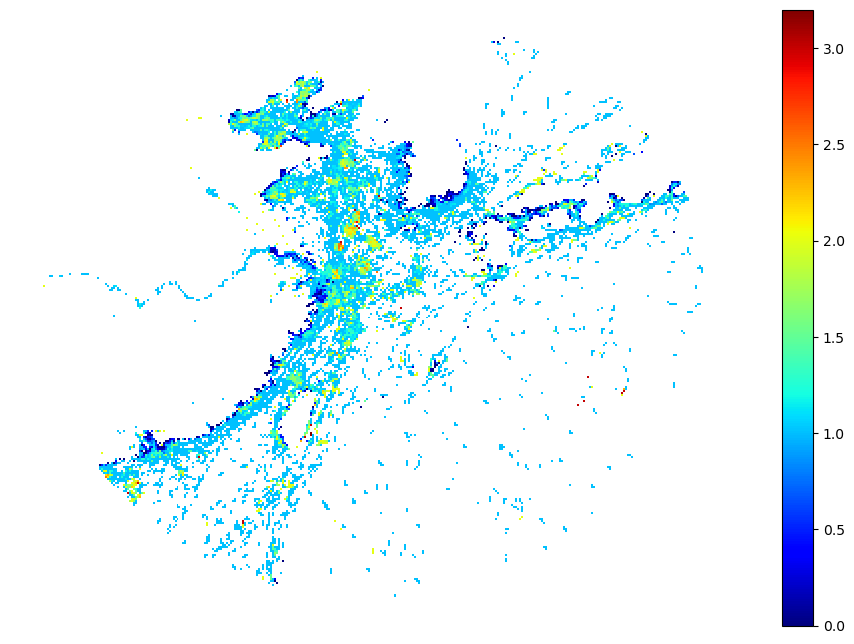

In [74]:
## lets plot our cells colored by the hot score column! 
fig, ax = plt.subplots(figsize=(12, 8))
combined_geo.plot(ax=ax, column='hot_score', cmap='jet', legend=True, aspect=1)
#gdf.plot(ax=ax, markersize=0.005, column='tester', cmap='jet')
ax.axis('off')
plt.show()

(106.54500000000009, 142.95499999999802, 13.395000000000001, 44.30499999999989)

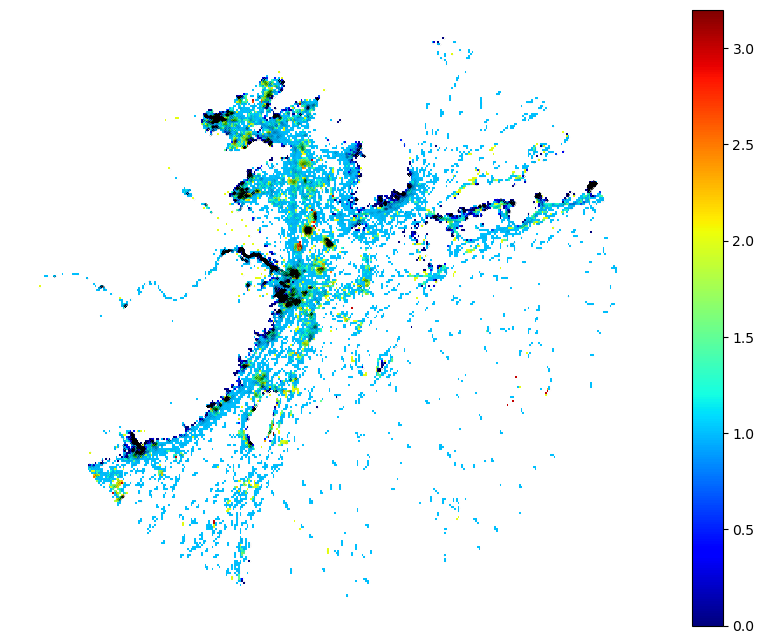

In [76]:
## lets plot our cells colored by the hot score column! 
#fig, ax = plt.subplots(figsize=(12, 8))
#combined_geo.plot(ax=ax, column='hot_score', cmap='jet', legend=True, aspect=1)
#merged.plot(ax=ax, color='black', markersize=.00001, alpha=0.5)  # Adjust color and markersize as needed
#ax.axis('off')
#plt.show()

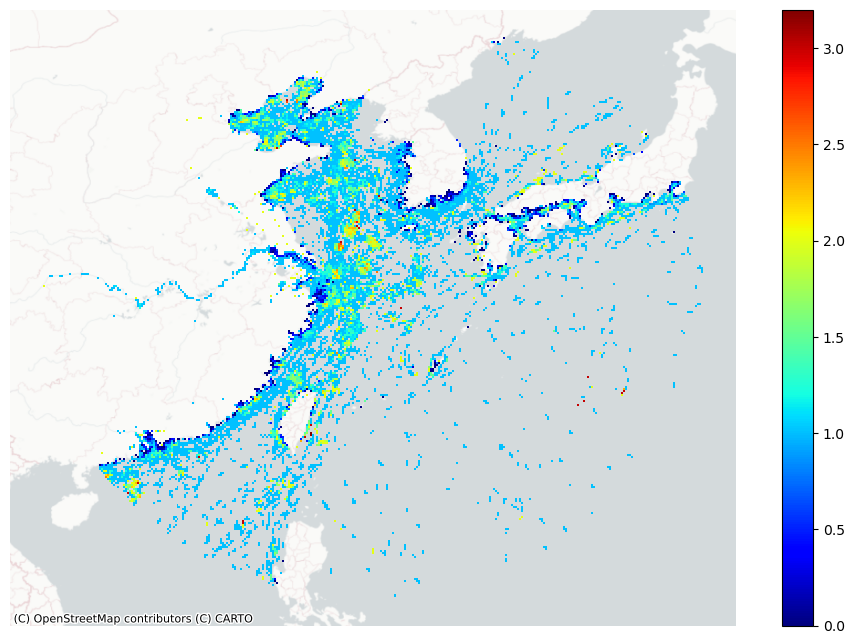

In [77]:
# Plot the cells colored by the hot score
fig, ax = plt.subplots(figsize=(12, 8))
combined_geo.plot(ax=ax, column='hot_score', cmap='jet', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=combined_geo.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')
# Show the plot
plt.show()

In [25]:
## Lets look at this again but this time ignoring coastal waters! 
## territrial coastal waters are seen as 12 nautical miles.
## we assume illegal fishing will be outside this territory
no_coast  = merged[merged['distance_to_coast'] > 12]

## perform same operations as above
unique_mmsi = no_coast.groupby('grid_num')['mmsi'].nunique().reset_index(name='unique_mmsi_count')
test = no_coast.drop_duplicates(subset=['grid_num', 'mmsi'])
unique_red_flags = test.groupby('grid_num')['red_flags'].sum().reset_index(name='total_red_flags')
combined_df = unique_mmsi.merge(unique_red_flags, on='grid_num')
combined_df['hot_score'] = combined_df['total_red_flags'] / combined_df['unique_mmsi_count']
combined = pd.merge(combined_df, grid_df[['geometry']], left_on='grid_num', right_index=True)
combined_geo = gpd.GeoDataFrame(combined, geometry='geometry')

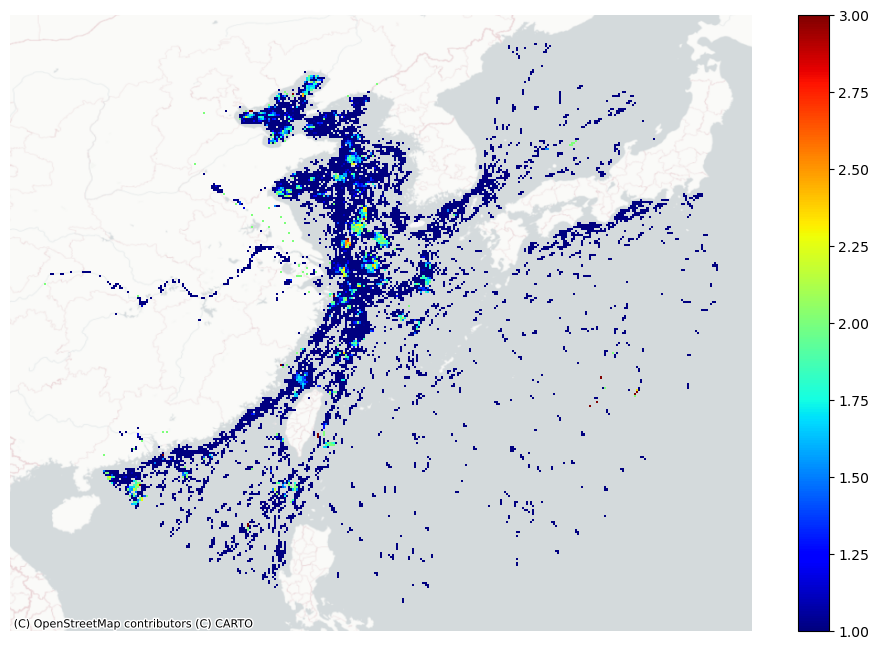

In [26]:
# Plot the cells colored by the hot score
fig, ax = plt.subplots(figsize=(12, 8))
combined_geo.plot(ax=ax, column='hot_score', cmap='jet', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=combined_geo.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')
# Show the plot
plt.show()

In [ ]:
## We see there is alot more dark blue spots 
## lets try both ignoring and not ignoring coastal boats below

## Concising code into Functions

In [1]:
## We have hot spots for 2 hours in the code above, however we wanna find the hot spot averages over the course of a day and eventually a week.

## Idea #1 -- findimg hot scores for each hour and then adding them up (see which cells have the highest red scores) 
    ## should i divide by 24 or no? Do I need an average or should i do a running total?

## Idea #2 --  I could implement sams code into this somehow - if each ais signal is marked as sus or not I can either add that as another red flag
    ## or just plot those points 
    
## Idea #3 -- I can do running total of red flags for each day and then add them all up over the course of a week and then divide by 7. We can see 
    ## the weekly average hot score for certain cells
    
## Idea #4 -- is there a secific algorithm or method I should be using here 

In [2]:
## make data pre-procesing into one function

def check_net_name(name):
    name = name.lower()
    net_name = ('%' in name or 
                'buoy' in name or 
                'net' in name or 
                bool(re.search(r"\d+v", name)))
    if net_name is np.nan:
        net_name = 0
    return net_name

## first chunk of pre-processing
def pre_process(df):
    # Convert 'dtg' to datetime and sort
    df['dtg'] = pd.to_datetime(df['dtg'])
    df = df.sort_values(['mmsi', 'dtg'])
    
    # Fill NA vessel names
    df.loc[df['vessel_name'].isnull(), 'vessel_name'] = " "
    
    # Calculate time difference between consecutive rows for each mmsi
    df['time_diff'] = df.groupby('mmsi')['dtg'].diff()
    
    # Identify first occurrence based on time difference
    df['first_occurrence'] = ((df['time_diff'].isnull()) | (df['time_diff'] > pd.Timedelta(hours=10))).astype(int)
    df['occ_num'] = df.groupby('mmsi').agg(occ_num = ('first_occurrence', 'cumsum'))
    
    # Calculate distance traveled
    df['old_lat'] = df.groupby(['mmsi', 'occ_num'])['latitude'].shift(1)
    df['old_long'] = df.groupby(['mmsi', 'occ_num'])['longitude'].shift(1)
    
    def calculate_distance(row):
        if pd.notna(row['old_lat']) and pd.notna(row['old_long']) and pd.notna(row['latitude']) and pd.notna(row['longitude']):
            return geodesic((row['old_lat'], row['old_long']), (row['latitude'], row['longitude'])).nautical
        else:
            return pd.NA

    df['distance'] = df.apply(calculate_distance, axis = 1)
    df['distance'] = pd.to_numeric(df['distance'], errors='coerce').fillna(0)
    df['speed'] = df['distance'] / (df['time_diff'].dt.seconds.replace(0, pd.NA) / 3600)
    df['distance'] = df.groupby(['mmsi', 'occ_num']).agg(distance = ('distance', 'cumsum'))
    
    ## check naming conventions
    ship_names = df['vessel_name'].astype('str').unique()
    net_names = [check_net_name(name) for name in ship_names]
    df['net_name'] = df['vessel_name']\
    .map(dict(zip(ship_names, net_names)))
    df['net_name'] = df.groupby(['mmsi', 'occ_num'])['net_name'].transform('max')

    ## bad mmsi checker 
    df['mmsi_length'] = df['mmsi'].astype('str').str.len() != 9
    
    del ship_names, net_names
    
    return df

## get coastline coordinates
def distance_to_coast(df, coastline):
    # Get coordinates of all of the ships
    ship_coords = list(df.apply(lambda x: (x.longitude, x.latitude), 
                                axis = 1))
        # Get coordinates of the coastlines
        
    coast_coords = [] 
    for geom in coastline.geometry:
        if geom.geom_type == 'Polygon':
            coast_coords.extend(list(geom.exterior.coords))
        elif geom.geom_type == 'MultiPolygon':
            for polygon in geom.geoms:
                coast_coords.extend(list(polygon.exterior.coords))
                    
    # Use KDTree to find the nearest points to each ship
    tree = KDTree(coast_coords)
    idx = tree.query(ship_coords, k=1)[1]
    coast_points = pd.Series(coast_coords).iloc[idx]
        
    # Get the distances in nautical miles
    naut_dist = [geodesic((ship[1], ship[0]), (coast[1], coast[0])).nautical 
                 for ship, coast 
                 in zip(ship_coords, list(coast_points))]
    
    # Insert into the dataframe
    df['distance_to_coast'] = naut_dist
    
    return df

## red flag calculator 
def red_flags(df):

 #   spawn_dict = {}
  #  for index, row in new_vessels.iterrows():
   #     key = (row['mmsi'], row['occ_num'])
    #    spawn_dict[key] = row['spawn_offshore']
        
    df['spawn_offshore'] = df.apply(lambda row: (row['mmsi'], row['occ_num']), axis=1).map(spawn_dict)
    df['spawn_offshore'] = df['spawn_offshore'].fillna(False)
    
    df['spoof'] = df['speed'] >= 150 # World record is 58.1, so allow for some measurement error 
    df['spoof'] = df.groupby(['mmsi', 'occ_num'])['spoof'].transform('max')
    
    df['red_flags'] = df['net_name'].astype('int') + df['mmsi_length'].astype('int') + df['spawn_offshore'].astype('int') + df['spoof'].astype('int')
    df.loc[:, ['mmsi', 'occ_num', 'longitude', 'latitude', 'sog', 'cog',
               'rot', 'distance', 'dtg', 'distance_to_coast', 'net_name', 'mmsi_length', 'spawn_offshore', 'spoof', 'red_flags']]
                               
    return df

In [3]:
## now lets make our geopandas concise 

def geo_frame(df, grid_df, crs):
    gdf = geopandas.GeoDataFrame(df, 
            geometry=geopandas.points_from_xy(df.longitude, df.latitude),
            crs=crs)
    
    gdf = gdf.drop(columns=['latitude', 'longitude'])
        
    ## associate each point with its grid cell
    merged = geopandas.sjoin(gdf, grid_df, how='left', predicate='intersects')
    merged.rename(columns={'index_right': 'grid_num'}, inplace=True)
    
    unique_mmsi = merged.groupby('grid_num')['mmsi'].nunique().reset_index(name='unique_mmsi_count')

    ## want total number of red flags per unique mmsi per cell
    test = merged.drop_duplicates(subset=['grid_num', 'mmsi'])
    unique_red_flags = test.groupby('grid_num')['red_flags'].sum().reset_index(name='total_red_flags')

    ## merge columns together
    combined_df = unique_mmsi.merge(unique_red_flags, on='grid_num')

    ## want to divide number of red flags by number of vessels to get a red flag score (#vessels / #red flags)
    combined_df['hot_score'] = combined_df['total_red_flags'] / combined_df['unique_mmsi_count']

    ## add in geometry of grid cell 
    combined = pd.merge(combined_df, grid_df[['geometry']], left_on='grid_num', right_index=True)
    combined_geo = gpd.GeoDataFrame(combined, geometry='geometry')
    
    return combined_geo

## Finding Hot Spot Averages for a Day/Week

In [17]:
## Want to combine all this into loop where:

## 1. our data is processed to have all the right columns
## 2. data is transformed into a geodataframe 
## 3. All our hot scores/per cell for each hour are tallied up for the day
## 4. Daily totals/per cell are all added up for week and divided by 7 to find average

In [8]:
## Part 1 - make loop for one day (September 1st)

# Set dtypes to avoid errors later
dtypes = {'FID': 'object', 'mmsi': 'int64', 'source_id': 'int64', 'imo': 'float64', 
          'vessel_name': 'object', 'callsign': 'object', 'vessel_type': 'object', 
          'vessel_type_code': 'float64', 'vessel_type_cargo': 'object', 'vessel_class': 'object',
          'length': 'float64', 'width': 'float64', 'flag_country': 'object', 'flag_code': 'float64',
          'destination': 'object', 'eta': 'int64', 'draught': 'float64', 'position': 'object',
          'latitude': 'float64', 'longitude': 'float64', 'sog': 'float64', 'cog': 'float64',
          'rot': 'float64', 'heading': 'int64', 'nav_status': 'object', 'nav_status_code': 'int64',
          'source': 'object', 'ts_pos_utc': 'int64', 'ts_static_utc': 'int64', 
          'dt_pos_utc': 'object', 'dt_static_utc': 'object', 'vessel_type_main': 'float64',
          'vessel_type_sub': 'float64', 'message_type': 'int64', 'eeid': 'float64', 'dtg': 'object'}

## files you want to calcualte hot spots for
this_dir = "/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01"

## all files (sored) within the directory 
files = glob.glob(this_dir + '/*.csv')
sorted_files = sorted(files)[1:6]

## read data in as csv <-- putting this in loop 
#hour = pd.read_csv(sorted_files, dtype=dtypes)

## coastline data and restricted coordinates
coastline = pd.concat([gpd.read_file("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/data/ne_10m_land/ne_10m_land.shp"), 
                       gpd.read_file("/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/data/ne_10m_minor_islands/ne_10m_minor_islands.shp")])
coastline = coastline.cx[107-1:142+1, 14-1:44+1].geometry

## set bounds for our map and cell sizes
cell_size = 0.1
xmin, ymin, xmax, ymax= 107, 14, 142, 44
    
x_range = np.arange(np.floor(xmin), np.ceil(xmax), cell_size)
y_range = np.arange(np.floor(ymin), np.ceil(ymax), cell_size)

## coordinate reference 
crs = "EPSG:4326"
    
## create uniform grid to overlay all datasets
grid_cells = []
for x in x_range:
    for y in y_range:
        cell_polygon = shapely.geometry.box(x, y, x + cell_size, y + cell_size)
        grid_cells.append(cell_polygon)

grid_df = geopandas.GeoDataFrame(geometry=grid_cells, crs=crs)


In [9]:
sorted_files

['/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01/ais_east_asia_20230901-0100.csv',
 '/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01/ais_east_asia_20230901-0200.csv',
 '/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01/ais_east_asia_20230901-0300.csv',
 '/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01/ais_east_asia_20230901-0400.csv',
 '/sfs/gpfs/tardis/project/SDS/capstones/ds6013/iuu_fishing/retry2/subfolder_September01/ais_east_asia_20230901-0500.csv']

In [10]:
## begin our loop 

## make empty df to store our columns
combined_df = pd.DataFrame(columns=["grid_num", "hot_score"])

for file in sorted_files:
    ## read in each hour as a csv
    hour = pd.read_csv(file, dtype=dtypes)
    
    ## pre-process data
    pt1 = pre_process(hour)

    ## middle code couldnt put into function
    new_vessels = pt1.loc[pt1['first_occurrence'] == 1, ['mmsi', 'occ_num', 'latitude', 'longitude']]
    new_vessels = distance_to_coast(new_vessels, coastline)
    new_vessels['spawn_offshore'] = new_vessels['distance_to_coast'] >= 1
    pt1 = pd.merge(pt1, new_vessels[['mmsi', 'occ_num', 'distance_to_coast']], on=['mmsi', 'occ_num'], how='left')
    
    spawn_dict = {}
    for index, row in new_vessels.iterrows():
        # Combine mmsi and occ_num to create the key
        key = (row['mmsi'], row['occ_num'])
        # Assign the value of 'spawn_offshore' to the key in the dictionary
        spawn_dict[key] = row['spawn_offshore']
    
    ## calculate red flags 
    pt2 = red_flags(pt1)

    ## convert to geo frame
    final = geo_frame(pt2, grid_df, crs)
    
    ## concatenate the final df to the empty df
    combined_df = pd.concat([combined_df, final[['grid_num', 'hot_score', 'geometry']]], ignore_index=True)

total_hot_score = combined_df.groupby("grid_num").agg({'hot_score': 'sum', 'geometry': 'first'}).reset_index()


In [11]:
total_hot_score.sort_values('hot_score', ascending=False)

,grid_num,hot_score,geometry
45,13268,13.500000,"POLYGON ((111.50000 20.80000, 111.50000 20.900..."
93,14468,13.333333,"POLYGON ((111.90000 20.80000, 111.90000 20.900..."
9737,52420,13.000000,"POLYGON ((124.50000 36.00000, 124.50000 36.100..."
8567,49327,13.000000,"POLYGON ((123.50000 26.70000, 123.50000 26.800..."
2781,37743,12.471160,"POLYGON ((119.60000 38.30000, 119.60000 38.400..."
...,...,...,...
11846,61921,0.000000,"POLYGON ((127.70000 26.10000, 127.70000 26.200..."
542,20191,0.000000,"POLYGON ((113.80000 23.10000, 113.80000 23.200..."
541,20187,0.000000,"POLYGON ((113.80000 22.70000, 113.80000 22.800..."
13288,70385,0.000000,"POLYGON ((130.50000 32.50000, 130.50000 32.600..."


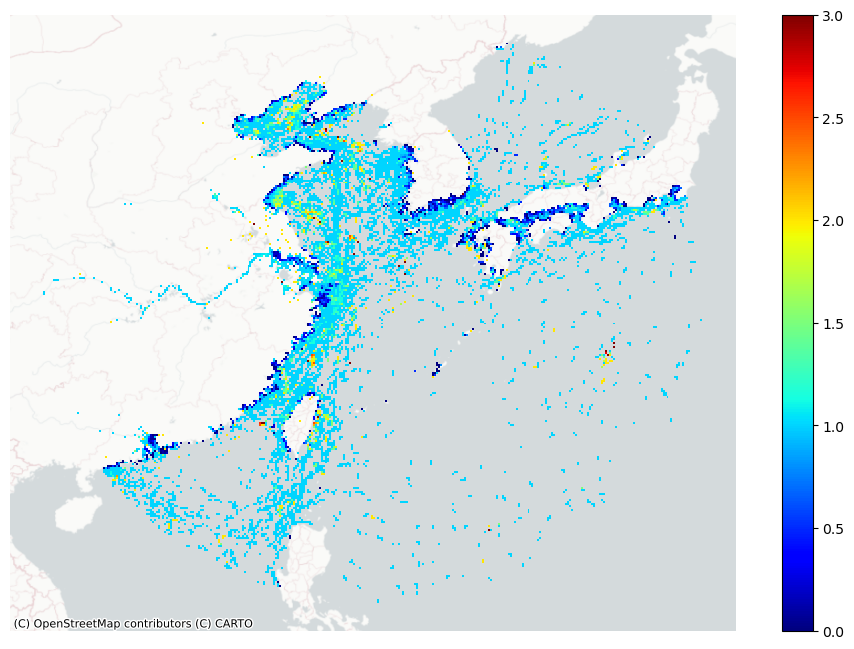

In [70]:
from matplotlib.colors import LinearSegmentedColormap

gdf = geopandas.GeoDataFrame(total_hot_score, 
            geometry='geometry',
            crs=crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='hot_score', cmap='jet', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')
# Show the plot
plt.show()

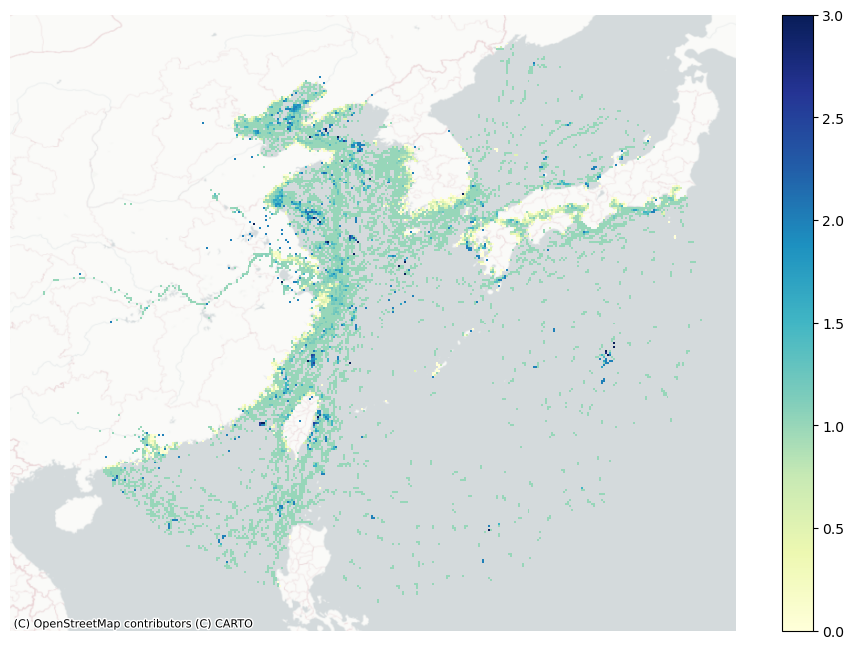

In [66]:
import matplotlib as mpl

cmap = mpl.cm.Blues(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[10:,:-1])

gdf = geopandas.GeoDataFrame(total_hot_score, 
            geometry='geometry',
            crs=crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='hot_score', cmap='YlGnBu', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')
# Show the plot
plt.show()

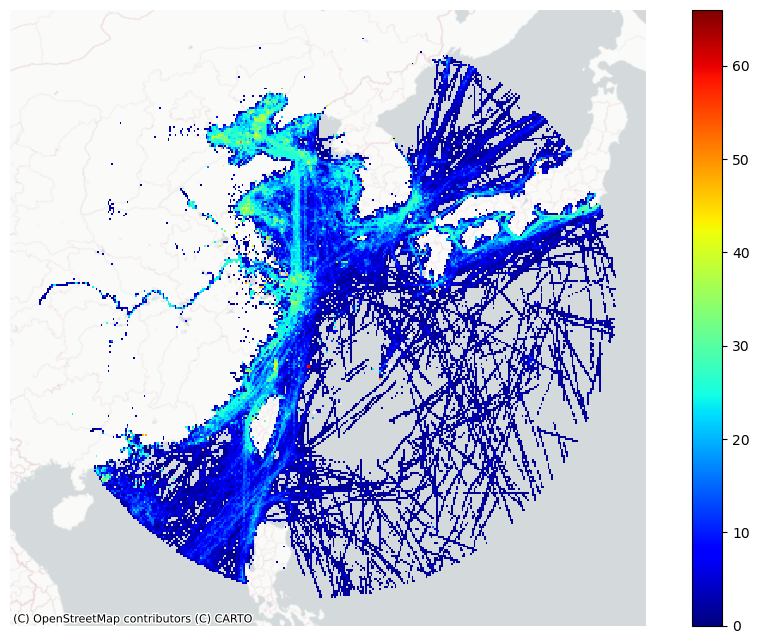

In [97]:
# Plot the cells colored by the hot score

gdf = geopandas.GeoDataFrame(total_hot_score, 
            geometry='geometry',
            crs=crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='hot_score', cmap='jet', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')

#top = total_hot_score[total_hot_score['grid_num'] == 49327]

# Create a GeoDataFrame from the filtered data
gdf_top = geopandas.GeoDataFrame(top, geometry='geometry', crs=crs)

# Plot the specific grid with its color
gdf_top.plot(ax=ax, facecolor='red', edgecolor='red')

# Show the plot
plt.show()

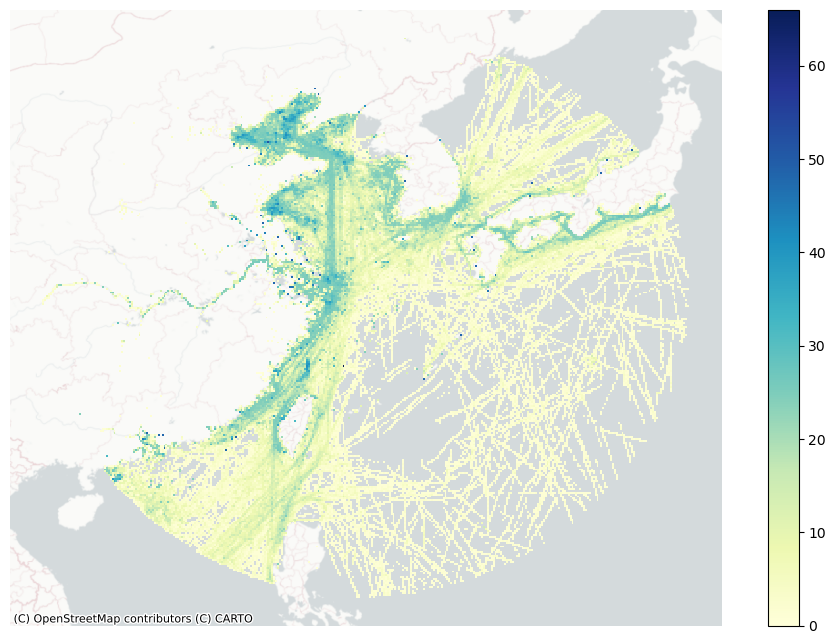

In [73]:
# Plot the cells colored by the hot score

gdf = geopandas.GeoDataFrame(total_hot_score, 
            geometry='geometry',
            crs=crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='hot_score', cmap='YlGnBu', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')

# Show the plot
plt.show()

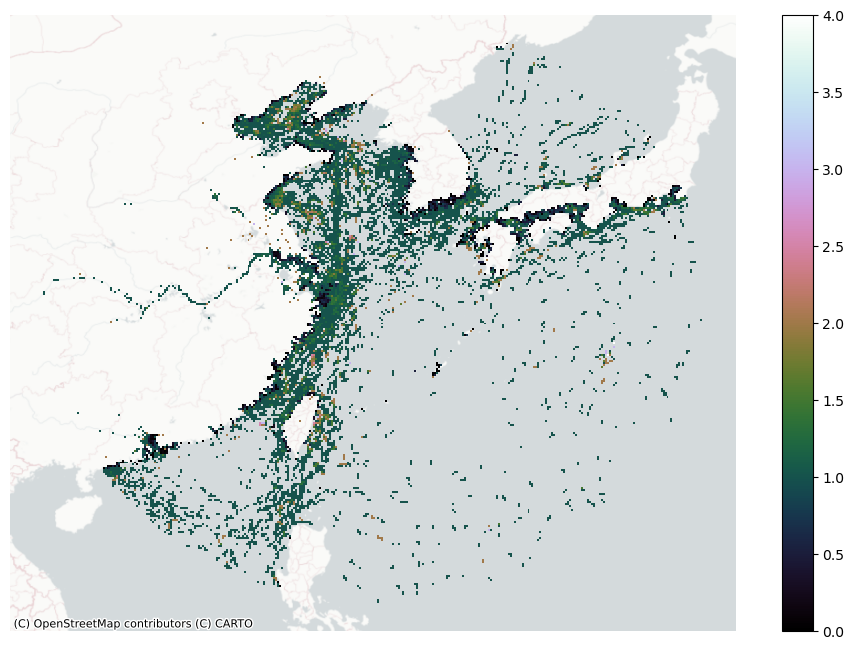

In [57]:
import matplotlib.colors as mcolors
# Create a custom colormap
colors = [(224,236,244), (127,205,187), (227,74,51)]  # RGB values for blue, white, and red
cmap_name = 'custom_cmap'
custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)


# Plot the cells colored by the hot score
gdf = geopandas.GeoDataFrame(total_hot_score, 
            geometry='geometry',
            crs=crs)

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, column='hot_score', cmap='cubehelix', legend=True)
# Overlay the basemap
ctx.add_basemap(ax,
                crs=gdf.crs.to_string(),
                source=ctx.providers.CartoDB.PositronNoLabels)
# Hide axis
ax.axis('off')
# Show the plot
plt.show()

In [ ]:
total_hot_score

## DBSCAN

In [3]:
## DBSCAN 

## Noise - points outside cluster
## Cores - poitns inside cluster with at least m points in 
## cluster within distance r
## Borders - points inside cluster with less than m other points in cluster 
## within distance r 

# Define DBSCAN
clusterer = DBSCAN()
# Fit to our data
#ais_coords = ais[['latitude', 'longitude']].applymap(radians)
clusterer.fit(ais[["longitude", "latitude"]])
## print the first 5 labels
clusterer.labels_[:5]

NameError: name 'DBSCAN' is not defined

In [ ]:
lbls = pandas.Series(clusterer.labels_, index=db.index)

In [ ]:
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (tw) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()

In [ ]:
# Obtain the number of points 1% of the total represents
minp = numpy.round(sept1.shape[0] * 0.01)
minp

In [ ]:
# Rerun DBSCAN
clusterer = DBSCAN(eps=500, min_samples=int(minp))
clusterer.fit(db[["x", "y"]])
# Turn labels into a Series
lbls = pandas.Series(clusterer.labels_, index=db.index)
# Setup figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Subset points that are not part of any cluster (noise)
noise = db.loc[lbls == -1, ["x", "y"]]
# Plot noise in grey
ax.scatter(noise["x"], noise["y"], c="grey", s=5, linewidth=0)
# Plot all points that are not noise in red
# NOTE how this is done through some fancy indexing, where
#      we take the index of all points (db) and substract from
#      it the index of those that are noise
ax.scatter(
    db.loc[db.index.difference(noise.index), "x"],
    db.loc[db.index.difference(noise.index), "y"],
    c="red",
    linewidth=0,
)
# Add basemap
contextily.add_basemap(
    ax, source=contextily.providers.CartoDB.Positron
)
# Remove axes
ax.set_axis_off()
# Display the figure
plt.show()